In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import nengo
import nengolib

In [3]:
def install_tuning_curves(ens):
    """Use ens.seed to set ens.{max_rates, intercepts, gain, bias}."""
    rng = np.random.RandomState(ens.seed)
    ens.max_rates = ens.max_rates.sample(ens.n_neurons, rng=rng)
    ens.intercepts = ens.intercepts.sample(ens.n_neurons, rng=rng)
    ens.gain, ens.bias = ens.neuron_type.gain_bias(
        ens.max_rates, ens.intercepts)
    

def go(n_neurons=100, ens_seed=0, tau=0.1, freq=5, dt=0.001, t=1.0,
       tau_rc=0.02, tau_ref=0.002, tau_n=1.0, inc_n=0.01):
    
    A = 2*np.pi*freq
    c = dt / (1 - np.exp(-dt/tau))  # principle 3 scaling for discrete lowpass
    
    with nengolib.Network() as model:
        stim = nengo.Node(output=lambda t: A*np.cos(A*t))
        
        lif_rep = nengo.Node(size_in=1)
        alif_rep = nengo.Node(size_in=1)
        
        lif = nengo.Ensemble(
            n_neurons, 1, seed=ens_seed,
            neuron_type=nengo.LIF(tau_rc=tau_rc, tau_ref=tau_ref))
        alif = nengo.Ensemble(
            n_neurons, 1, seed=ens_seed,
            neuron_type=nengo.AdaptiveLIF(tau_n=tau_n, inc_n=inc_n,
                                          tau_rc=tau_rc, tau_ref=tau_ref))
        install_tuning_curves(lif)     
        install_tuning_curves(alif)
        assert np.allclose(lif.max_rates, alif.max_rates)
        assert np.allclose(lif.intercepts, alif.intercepts)
        assert np.allclose(lif.gain, alif.gain)
        assert np.allclose(lif.bias, alif.bias)

        # LIF Principle 3
        nengo.Connection(stim, lif_rep, transform=c, synapse=tau)
        nengo.Connection(lif, lif_rep, synapse=tau)
        nengo.Connection(lif_rep, lif, synapse=None)
        
        # aLIF Principle 3
        nengo.Connection(stim, alif_rep, transform=c, synapse=tau)
        nengo.Connection(alif, alif_rep, synapse=tau)
        nengo.Connection(alif_rep, alif, synapse=None)
        recurrent_synapse = (alif.neuron_type.inc_n * nengolib.signal.cont2discrete(
                nengo.Lowpass(alif.neuron_type.tau_n), dt=dt, method='euler'))
        nengo.Connection(alif.neurons, alif.neurons,  # <-- compensating connection
                         transform=1/alif.gain, synapse=recurrent_synapse)
        
        p_lif = nengo.Probe(lif_rep, synapse=None)
        p_alif = nengo.Probe(alif_rep, synapse=None)
        
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)
    
    plt.figure()
    plt.plot(sim.trange(), sim.data[p_alif], label="aLIF", alpha=0.8)
    plt.plot(sim.trange(), sim.data[p_lif], label="LIF", lw=3, linestyle='--') 
    plt.legend()
    plt.show()
    
    assert np.allclose(sim.data[p_lif], sim.data[p_alif])

Building finished in 0:00:01.                                                   


c:\users\aaron\ctn\nengolib\nengolib\signal\system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:00:01.                                                 


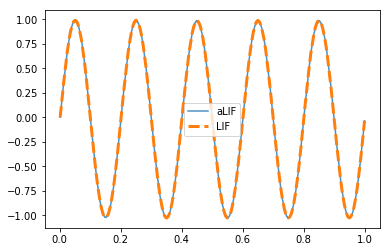

In [4]:
go()